In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from experiment_utils import *
from src import *
import numpy as np



pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


In [ ]:
def plot_baf(preds, preds_base, X, y, title, sensitive_attrs):
    """
    plot scatter of preds vs preds_base.
    color points based on combinations of sensitive attributes in X, with names of the sens columns given in sensitive_attrs.
    """
    fig, ax = plt.subplots()
    
    # Create unique combinations of sensitive attributes
    unique_combinations = np.unique(X[sensitive_attrs].to_numpy(), axis=0)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_combinations*2)))
    color_dict = {tuple(combination): color for combination, color in zip(unique_combinations, colors)}
    
        
    # Create unique combinations of sensitive attributes
    unique_combinations = np.unique(X[sensitive_attrs].to_numpy(), axis=0)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_combinations)*2))    
    color_dict = {}
    for i, combo in enumerate(unique_combinations):
        color_dict[tuple(combo)] = colors[i*2:(i+1)*2]
    
    print(colors) 
    print(color_dict)
    
    # Add lines at x and y axes
    ax.axhline(0.5, color='black', linestyle='--', linewidth=1)
    ax.axvline(0.5, color='black', linestyle='--', linewidth=1)
    
    label_mask = (y == 1)
    # Scatter plot with color based on combinations of sensitive attributes
    for combination in unique_combinations:
        mask = np.all(X[sensitive_attrs].to_numpy() == combination, axis=1)
        ax.scatter(preds_base[mask & label_mask], preds[mask & label_mask], label=str(combination), color=color_dict[tuple(combination)][0], marker='s', alpha=0.5, s=20, edgecolor='none')
        ax.scatter(preds_base[mask & ~label_mask], preds[mask & ~label_mask], label=str(combination), color=color_dict[tuple(combination)][1], alpha=0.5, s=20, edgecolor='none')
    
    # Add labels and title
    ax.set_xlabel('Predictions Base Model')
    ax.set_ylabel('Predictions Model')
    ax.set_title(title)
    
    # Add legend
    ax.legend(title=sensitive_attrs)
    
    plt.show()


In [ ]:

comment= "check l"

epochs = 1500
results_filename = "BAF_mod"
other = {}
datasets = [Tester.ADULT_D] #[Tester.ADULT_D,  Tester.COMPAS_D]#, Tester.GERMAN_D, Tester.ADULT_D,], Tester.COMPAS_D, 
latent_dims = [25]
metric_names = [Metrics.ACC, Metrics.SF]
losses = [[VAEMaskConfig.LATENT_S_ADV_LOSS, VAEMaskConfig.POS_VECTOR_LOSS,        VAEMaskConfig.RECON_LOSS, VAEMaskConfig.KL_DIV_LOSS]]

for dataset, dim in zip(datasets, latent_dims):
    for s in [["sex","race"]]: #  ["sex","race"],["race"],["sex"]
        print("="*100)
        print(dataset, s)

        config = VAEMaskConfig(epochs=epochs, latent_dim=dim, lr=0.014, losses_used=losses[0])
        config.config_loss(config.RECON_LOSS, weight = 40)

        mls = [TestConfig(Tester.FYP_VAE, Model.MLP_C, sensitive_attr=s, other={"c": comment, VAEMaskModel.VAE_MASK_CONFIG:  config})]
        base = TestConfig(Tester.BASE_ML, Model.MLP_C , sensitive_attr = s)
        results_file = os.path.join("results",results_filename +"_".join(s)+".csv")
        tester = Tester(results_file, dataset, metric_names)
        for ml in mls:
            print("-"*100)
            print(ml.bias_mit)
            tester.run_tests([ml, base], 3, save_intermid_results=True)
            preds, X, y = tester.get_last_run()
            
            plot_baf(preds[0], preds[1], X, y, ml.bias_mit + '|' + dataset, s)
                
            

Adult Dataset ['sex', 'race']
{'weight': 0.1, 'lr': 0.05, 'optimizer': 'Adam', 'layers': (30, 30), 'input_dim': None}
{'weight': 0.005}
----------------------------------------------------------------------------------------------------
FYP VAE
input dim: 25
{(1.0, 1.0): 0.5891004641004641, (0.0, 1.0): 0.26617526617526616, (1.0, 0.0): 0.07998907998907999, (0.0, 0.0): 0.06473518973518974}
{(1.0, 1.0): 0.5891004641004641, (0.0, 1.0): 0.26617526617526616, (1.0, 0.0): 0.07998907998907999, (0.0, 0.0): 0.06473518973518974}
DISCR LAYERS [23, 30, 30]
DISCR LAYERS [23, 30, 30]
[[0.267004 0.004874 0.329415 1.      ]
 [0.275191 0.194905 0.496005 1.      ]
 [0.212395 0.359683 0.55171  1.      ]
 [0.153364 0.497    0.557724 1.      ]
 [0.122312 0.633153 0.530398 1.      ]
 [0.288921 0.758394 0.428426 1.      ]
 [0.626579 0.854645 0.223353 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]
{(0.0, 0.0): array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.275191, 0.194905, 0.496005, 1.      ]]),

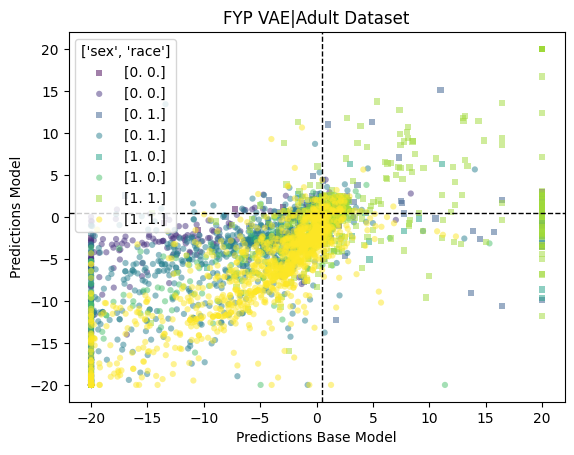

In [3]:

comment= "PREDICT LOG PROBA, more weight recon, diff loss for vae"

epochs = 500
results_filename = "BAF_mod"
other = {}
datasets = [Tester.ADULT_D] #[Tester.ADULT_D,  Tester.COMPAS_D]#, Tester.GERMAN_D, Tester.ADULT_D,], Tester.COMPAS_D, 
latent_dims = [25]
metric_names = [Metrics.ACC, Metrics.SF]
losses = [[VAEMaskConfig.LATENT_S_ADV_LOSS, VAEMaskConfig.POS_VECTOR_LOSS,        VAEMaskConfig.RECON_LOSS, VAEMaskConfig.KL_DIV_LOSS]]

for dataset, dim in zip(datasets, latent_dims):
    for s in [["sex","race"]]: #  ["sex","race"],["race"],["sex"]
        print("="*100)
        print(dataset, s)

        config = VAEMaskConfig(epochs=epochs, latent_dim=dim, lr=0.014, losses_used=losses[0])
        config.config_loss(config.RECON_LOSS, weight = 40)

        mls = [TestConfig(Tester.FYP_VAE, Model.MLP_C, sensitive_attr=s, other={"c": comment, VAEMaskModel.VAE_MASK_CONFIG:  config})]
        base = TestConfig(Tester.BASE_ML, Model.MLP_C , sensitive_attr = s)
        results_file = os.path.join("results",results_filename +"_".join(s)+".csv")
        tester = Tester(results_file, dataset, metric_names)
        for ml in mls:
            print("-"*100)
            print(ml.bias_mit)
            tester.run_tests([ml, base], 1, save_intermid_results=True)
            preds, X, y = tester.get_last_run()
            
            plot_baf(preds[0], preds[1], X, y, ml.bias_mit + '|' + dataset, s)
                
            

Adult Dataset ['sex', 'race']
{'weight': 0.1, 'lr': 0.05, 'optimizer': 'Adam', 'layers': (30, 30), 'input_dim': None}
{'weight': 0.005}
----------------------------------------------------------------------------------------------------
FYP VAE
input dim: 25
{(1.0, 1.0): 0.5888274638274639, (1.0, 0.0): 0.08036445536445537, (0.0, 1.0): 0.2661411411411411, (0.0, 0.0): 0.06466693966693966}
{(1.0, 1.0): 0.5888274638274639, (1.0, 0.0): 0.08036445536445537, (0.0, 1.0): 0.2661411411411411, (0.0, 0.0): 0.06466693966693966}
DISCR LAYERS [23, 30, 30]
DISCR LAYERS [23, 30, 30]
------------------ <src.ml_models.FYP_VAE.losses.LatentDiscrLoss object at 0x0000018F13FB5B50> loss:   tensor(0.3718, grad_fn=<MulBackward0>)
------------------ <src.ml_models.FYP_VAE.losses.PositiveVectorLoss object at 0x0000018F13FB5AF0> loss:   tensor(0.0003, grad_fn=<MeanBackward1>)
------------------ <src.ml_models.FYP_VAE.losses.ReconstructionLoss object at 0x0000018F13FB5A60> loss:   tensor(0.3895, grad_fn=<MulBackwa

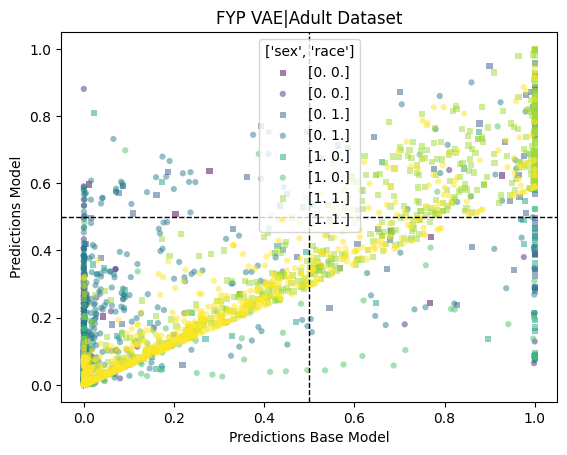

Compas Dataset ['sex', 'race']
{'weight': 0.1, 'lr': 0.05, 'optimizer': 'Adam', 'layers': (30, 30), 'input_dim': None}
{'weight': 0.005}
----------------------------------------------------------------------------------------------------
FYP VAE
input dim: 10
{(1.0, 0.0): 0.5426848128673059, (1.0, 1.0): 0.26492421899164864, (0.0, 1.0): 0.07794618001855862, (0.0, 0.0): 0.11444478812248686}
{(1.0, 0.0): 0.5426848128673059, (1.0, 1.0): 0.26492421899164864, (0.0, 1.0): 0.07794618001855862, (0.0, 0.0): 0.11444478812248686}
DISCR LAYERS [10, 30, 30]
DISCR LAYERS [10, 30, 30]
------------------ <src.ml_models.FYP_VAE.losses.LatentDiscrLoss object at 0x0000018F1D46CAC0> loss:   tensor(0.3464, grad_fn=<MulBackward0>)
------------------ <src.ml_models.FYP_VAE.losses.PositiveVectorLoss object at 0x0000018F1D46CAF0> loss:   tensor(0.0005, grad_fn=<MeanBackward1>)
------------------ <src.ml_models.FYP_VAE.losses.ReconstructionLoss object at 0x0000018F1D46CB20> loss:   tensor(0.6048, grad_fn=<MulBac

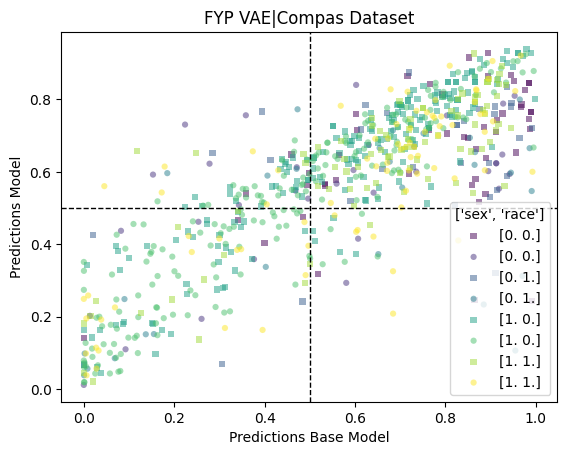

In [3]:

comment= "dont mask same to same"

epochs = 1300
results_filename = "BAF_mod"
other = {}
datasets = [Tester.ADULT_D, Tester.COMPAS_D] #[Tester.ADULT_D,  Tester.COMPAS_D]#, Tester.GERMAN_D, Tester.ADULT_D,], Tester.COMPAS_D, 
latent_dims = [25, 12]
metric_names = [Metrics.ACC, Metrics.SF]
losses = [[VAEMaskConfig.LATENT_S_ADV_LOSS, VAEMaskConfig.POS_VECTOR_LOSS,        VAEMaskConfig.RECON_LOSS, VAEMaskConfig.KL_DIV_LOSS]]

for dataset, dim in zip(datasets, latent_dims):
    for s in [["sex","race"]]: #  ["sex","race"],["race"],["sex"]
        print("="*100)
        print(dataset, s)

        mls = [
            TestConfig(Tester.FYP_VAE, Model.MLP_C, sensitive_attr=s, other={"c": comment, VAEMaskModel.VAE_MASK_CONFIG:  
                VAEMaskConfig(epochs=epochs, latent_dim=dim, lr=0.014, losses_used=l)}) for l in losses
            ]
        base = TestConfig(Tester.BASE_ML, Model.MLP_C , sensitive_attr = s)
        results_file = os.path.join("results",results_filename +"_".join(s)+".csv")
        tester = Tester(results_file, dataset, metric_names)
        for ml in mls:
            print("-"*100)
            print(ml.bias_mit)
            tester.run_tests([ml, base], 1, save_intermid_results=True)
            preds, X, y = tester.get_last_run()
            
            plot_baf(preds[0], preds[1], X, y, ml.bias_mit + '|' + dataset, s)
            
        

Adult Dataset ['sex', 'race']
{'weight': 0.1, 'lr': 0.05, 'optimizer': 'Adam', 'layers': (30, 30), 'input_dim': None}
{'weight': 0.005}
----------------------------------------------------------------------------------------------------
FYP VAE
input dim: 25
{(1.0, 1.0): 0.5876672126672127, (0.0, 1.0): 0.2661411411411411, (1.0, 0.0): 0.08043270543270543, (0.0, 0.0): 0.06575894075894076}
{(1.0, 1.0): 0.5876672126672127, (0.0, 1.0): 0.2661411411411411, (1.0, 0.0): 0.08043270543270543, (0.0, 0.0): 0.06575894075894076}
DISCR LAYERS [23, 30, 30]
DISCR LAYERS [23, 30, 30]
------------------ <src.ml_models.FYP_VAE.losses.LatentDiscrLoss object at 0x0000026A9AA1E8B0> loss:   tensor(0.3647, grad_fn=<MulBackward0>)
------------------ <src.ml_models.FYP_VAE.losses.PositiveVectorLoss object at 0x0000026A9AA1E250> loss:   tensor(0.0005, grad_fn=<MeanBackward1>)
------------------ <src.ml_models.FYP_VAE.losses.ReconstructionLoss object at 0x0000026A9AA1ED90> loss:   tensor(0.6733, grad_fn=<MulBackwa

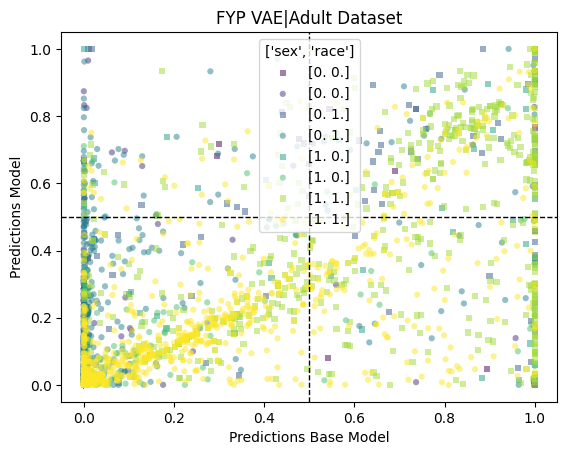

In [4]:

comment= "diff loss for vae"

epochs = 1300
results_filename = "BAF_mod"
other = {}
datasets = [Tester.ADULT_D] #[Tester.ADULT_D,  Tester.COMPAS_D]#, Tester.GERMAN_D, Tester.ADULT_D,], Tester.COMPAS_D, 
latent_dims = [25]
metric_names = [Metrics.ACC, Metrics.SF]
losses = [[VAEMaskConfig.LATENT_S_ADV_LOSS, VAEMaskConfig.POS_VECTOR_LOSS,        VAEMaskConfig.RECON_LOSS, VAEMaskConfig.KL_DIV_LOSS]]

for dataset, dim in zip(datasets, latent_dims):
    for s in [["sex","race"]]: #  ["sex","race"],["race"],["sex"]
        print("="*100)
        print(dataset, s)

        config = VAEMaskConfig(epochs=epochs, latent_dim=dim, lr=0.014, losses_used=losses[0])
        #config.config_loss(config.RECON_LOSS, weight = loss_params["w_recon"])

        mls = [TestConfig(Tester.FYP_VAE, Model.MLP_C, sensitive_attr=s, other={"c": comment, VAEMaskModel.VAE_MASK_CONFIG:  config})]
        base = TestConfig(Tester.BASE_ML, Model.MLP_C , sensitive_attr = s)
        results_file = os.path.join("results",results_filename +"_".join(s)+".csv")
        tester = Tester(results_file, dataset, metric_names)
        for ml in mls:
            print("-"*100)
            print(ml.bias_mit)
            tester.run_tests([ml, base], 1, save_intermid_results=True)
            preds, X, y = tester.get_last_run()
            
            plot_baf(preds[0], preds[1], X, y, ml.bias_mit + '|' + dataset, s)
            
        

In [ ]:
# TRY DONT MASK SAME TO SAME WITH eq weightings

Adult Dataset ['sex', 'race']
{'weight': 0.1, 'lr': 0.05, 'optimizer': 'Adam', 'layers': (30, 30), 'input_dim': None}
{'weight': 0.005}
----------------------------------------------------------------------------------------------------
FYP VAE
input dim: 25
{(1.0, 1.0): 0.5888957138957139, (0.0, 1.0): 0.2661411411411411, (0.0, 0.0): 0.06545181545181546, (1.0, 0.0): 0.07951132951132951}
{(1.0, 1.0): 0.5888957138957139, (0.0, 1.0): 0.2661411411411411, (0.0, 0.0): 0.06545181545181546, (1.0, 0.0): 0.07951132951132951}
DISCR LAYERS [23, 30, 30]
DISCR LAYERS [23, 30, 30]
------------------ <src.ml_models.FYP_VAE.losses.LatentDiscrLoss object at 0x0000026AA4C63070> loss:   tensor(0.3754, grad_fn=<MulBackward0>)
------------------ <src.ml_models.FYP_VAE.losses.PositiveVectorLoss object at 0x0000026AA4C635E0> loss:   tensor(0.0008, grad_fn=<MeanBackward1>)
------------------ <src.ml_models.FYP_VAE.losses.ReconstructionLoss object at 0x0000026AA4C637F0> loss:   tensor(1.0716, grad_fn=<MulBackwa

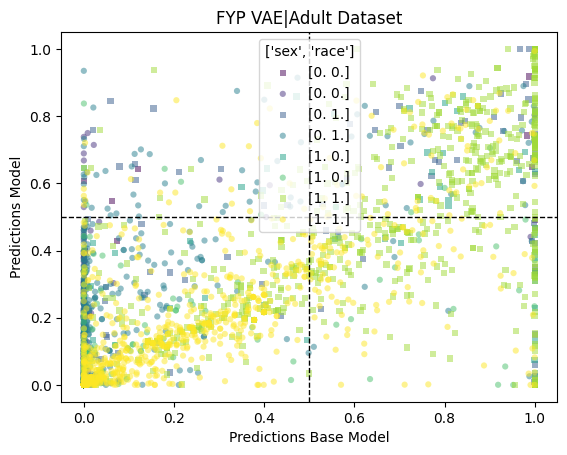

Adult Dataset ['sex', 'race']
{'weight': 0.1, 'lr': 0.05, 'optimizer': 'Adam', 'layers': (30, 30), 'input_dim': None}
{'weight': 0.005}
----------------------------------------------------------------------------------------------------
FYP VAE
input dim: 25
{(0.0, 1.0): 0.2654586404586405, (1.0, 1.0): 0.5891004641004641, (1.0, 0.0): 0.07992082992082992, (0.0, 0.0): 0.06552006552006552}
{(0.0, 1.0): 0.2654586404586405, (1.0, 1.0): 0.5891004641004641, (1.0, 0.0): 0.07992082992082992, (0.0, 0.0): 0.06552006552006552}
DISCR LAYERS [23, 30, 30]
DISCR LAYERS [23, 30, 30]
------------------ <src.ml_models.FYP_VAE.losses.LatentDiscrLoss object at 0x0000026AA4B52070> loss:   tensor(0.4379, grad_fn=<MulBackward0>)
------------------ <src.ml_models.FYP_VAE.losses.PositiveVectorLoss object at 0x0000026AA4B52E50> loss:   tensor(0.0020, grad_fn=<MeanBackward1>)
------------------ <src.ml_models.FYP_VAE.losses.ReconstructionLoss object at 0x0000026AA4B52B20> loss:   tensor(0.7715, grad_fn=<MulBackwa

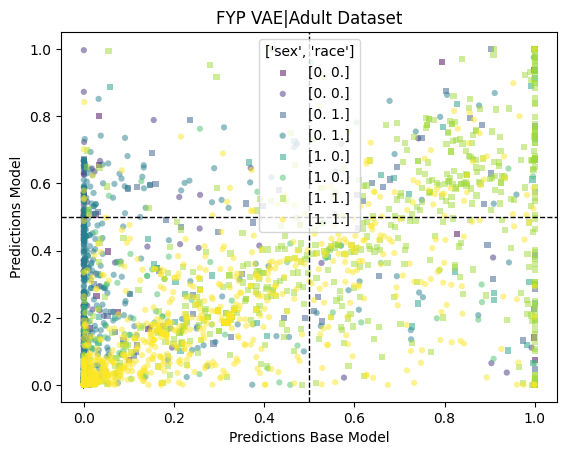

In [5]:

comment= "more weight recon, diff loss for vae"

epochs = 1400
results_filename = "BAF_mod"
other = {}
datasets = [Tester.ADULT_D] #[Tester.ADULT_D,  Tester.COMPAS_D]#, Tester.GERMAN_D, Tester.ADULT_D,], Tester.COMPAS_D, 
latent_dims = [25]
metric_names = [Metrics.ACC, Metrics.SF]
losses = [[VAEMaskConfig.LATENT_S_ADV_LOSS, VAEMaskConfig.POS_VECTOR_LOSS,        VAEMaskConfig.RECON_LOSS, VAEMaskConfig.KL_DIV_LOSS]]

for i in range(2):
    for dataset, dim in zip(datasets, latent_dims):
        for s in [["sex","race"]]: #  ["sex","race"],["race"],["sex"]
            print("="*100)
            print(dataset, s)

            config = VAEMaskConfig(epochs=epochs, latent_dim=dim, lr=0.014, losses_used=losses[0])
            config.config_loss(config.RECON_LOSS, weight = 25)

            mls = [TestConfig(Tester.FYP_VAE, Model.MLP_C, sensitive_attr=s, other={"c": comment, VAEMaskModel.VAE_MASK_CONFIG:  config})]
            base = TestConfig(Tester.BASE_ML, Model.MLP_C , sensitive_attr = s)
            results_file = os.path.join("results",results_filename +"_".join(s)+".csv")
            tester = Tester(results_file, dataset, metric_names)
            for ml in mls:
                print("-"*100)
                print(ml.bias_mit)
                tester.run_tests([ml, base], 1, save_intermid_results=True)
                preds, X, y = tester.get_last_run()
                
                plot_baf(preds[0], preds[1], X, y, ml.bias_mit + '|' + dataset, s)
                
            

Adult Dataset ['sex', 'race']
{'weight': 0.1, 'lr': 0.05, 'optimizer': 'Adam', 'layers': (30, 30), 'input_dim': None}
{'weight': 0.005}
----------------------------------------------------------------------------------------------------
FYP VAE
input dim: 25
{(1.0, 1.0): 0.5901924651924652, (0.0, 1.0): 0.2648102648102648, (0.0, 0.0): 0.06524706524706525, (1.0, 0.0): 0.07975020475020475}
{(1.0, 1.0): 0.5901924651924652, (0.0, 1.0): 0.2648102648102648, (0.0, 0.0): 0.06524706524706525, (1.0, 0.0): 0.07975020475020475}
DISCR LAYERS [23, 30, 30]
DISCR LAYERS [23, 30, 30]
------------------ <src.ml_models.FYP_VAE.losses.LatentDiscrLoss object at 0x0000026AA4B52460> loss:   tensor(0.4378, grad_fn=<MulBackward0>)
------------------ <src.ml_models.FYP_VAE.losses.PositiveVectorLoss object at 0x0000026AA4B52EE0> loss:   tensor(0.0030, grad_fn=<MeanBackward1>)
------------------ <src.ml_models.FYP_VAE.losses.ReconstructionLoss object at 0x0000026AA4B52130> loss:   tensor(1.1841, grad_fn=<MulBackwa

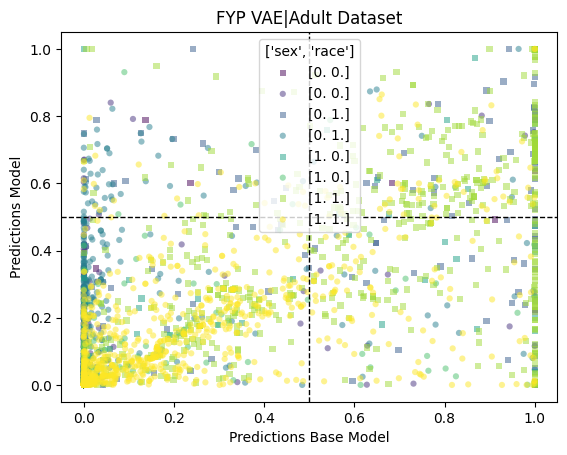

In [6]:

comment= "more weight recon, diff loss for vae"

epochs = 1500
results_filename = "BAF_mod"
other = {}
datasets = [Tester.ADULT_D] #[Tester.ADULT_D,  Tester.COMPAS_D]#, Tester.GERMAN_D, Tester.ADULT_D,], Tester.COMPAS_D, 
latent_dims = [25]
metric_names = [Metrics.ACC, Metrics.SF]
losses = [[VAEMaskConfig.LATENT_S_ADV_LOSS, VAEMaskConfig.POS_VECTOR_LOSS,        VAEMaskConfig.RECON_LOSS, VAEMaskConfig.KL_DIV_LOSS]]

for dataset, dim in zip(datasets, latent_dims):
    for s in [["sex","race"]]: #  ["sex","race"],["race"],["sex"]
        print("="*100)
        print(dataset, s)

        config = VAEMaskConfig(epochs=epochs, latent_dim=dim, lr=0.014, losses_used=losses[0])
        config.config_loss(config.RECON_LOSS, weight = 40)

        mls = [TestConfig(Tester.FYP_VAE, Model.MLP_C, sensitive_attr=s, other={"c": comment, VAEMaskModel.VAE_MASK_CONFIG:  config})]
        base = TestConfig(Tester.BASE_ML, Model.MLP_C , sensitive_attr = s)
        results_file = os.path.join("results",results_filename +"_".join(s)+".csv")
        tester = Tester(results_file, dataset, metric_names)
        for ml in mls:
            print("-"*100)
            print(ml.bias_mit)
            tester.run_tests([ml, base], 3, save_intermid_results=True)
            preds, X, y = tester.get_last_run()
            
            plot_baf(preds[0], preds[1], X, y, ml.bias_mit + '|' + dataset, s)
                
            

Adult Dataset ['sex', 'race']
{'weight': 0.1, 'lr': 0.05, 'optimizer': 'Adam', 'layers': (30, 30), 'input_dim': None}
{'weight': 0.005}
----------------------------------------------------------------------------------------------------
FYP VAE
input dim: 25
{(1.0, 0.0): 0.08114933114933115, (1.0, 1.0): 0.5878037128037128, (0.0, 0.0): 0.06545181545181546, (0.0, 1.0): 0.2655951405951406}
{(1.0, 0.0): 0.08114933114933115, (1.0, 1.0): 0.5878037128037128, (0.0, 0.0): 0.06545181545181546, (0.0, 1.0): 0.2655951405951406}
DISCR LAYERS [23, 30, 30]
DISCR LAYERS [23, 30, 30]
------------------ <src.ml_models.FYP_VAE.losses.LatentDiscrLoss object at 0x00000201EECAFEE0> loss:   tensor(0.3720, grad_fn=<MulBackward0>)
------------------ <src.ml_models.FYP_VAE.losses.PositiveVectorLoss object at 0x00000201EECAFB80> loss:   tensor(0.0019, grad_fn=<MeanBackward1>)
------------------ <src.ml_models.FYP_VAE.losses.ReconstructionLoss object at 0x00000201EECAFD90> loss:   tensor(1.2949, grad_fn=<MulBackwa

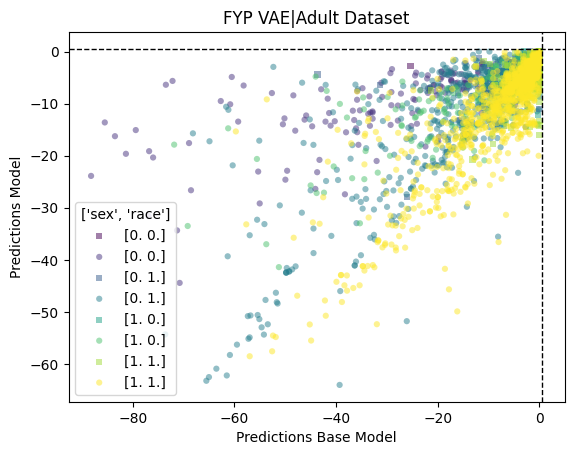

In [3]:

comment= "PREDICT LOG PROBA, more weight recon, diff loss for vae"

epochs = 1300
results_filename = "BAF_mod"
other = {}
datasets = [Tester.ADULT_D] #[Tester.ADULT_D,  Tester.COMPAS_D]#, Tester.GERMAN_D, Tester.ADULT_D,], Tester.COMPAS_D, 
latent_dims = [25]
metric_names = [Metrics.ACC, Metrics.SF]
losses = [[VAEMaskConfig.LATENT_S_ADV_LOSS, VAEMaskConfig.POS_VECTOR_LOSS,        VAEMaskConfig.RECON_LOSS, VAEMaskConfig.KL_DIV_LOSS]]

for dataset, dim in zip(datasets, latent_dims):
    for s in [["sex","race"]]: #  ["sex","race"],["race"],["sex"]
        print("="*100)
        print(dataset, s)

        config = VAEMaskConfig(epochs=epochs, latent_dim=dim, lr=0.014, losses_used=losses[0])
        config.config_loss(config.RECON_LOSS, weight = 40)

        mls = [TestConfig(Tester.FYP_VAE, Model.MLP_C, sensitive_attr=s, other={"c": comment, VAEMaskModel.VAE_MASK_CONFIG:  config})]
        base = TestConfig(Tester.BASE_ML, Model.MLP_C , sensitive_attr = s)
        results_file = os.path.join("results",results_filename +"_".join(s)+".csv")
        tester = Tester(results_file, dataset, metric_names)
        for ml in mls:
            print("-"*100)
            print(ml.bias_mit)
            tester.run_tests([ml, base], 1, save_intermid_results=True)
            preds, X, y = tester.get_last_run()
            
            plot_baf(preds[0], preds[1], X, y, ml.bias_mit + '|' + dataset, s)
                
            